# <center>nerf代码解读</center>

本文对pytorch官方的nerf-pytorch-master进行辅助解读, 解读逻辑按原代码展开的顺序，对<重要/难懂代码>模块进行注释。读者需要对论文有基本理解后，对比原代码一起观看，以减少代码阅读理解时间

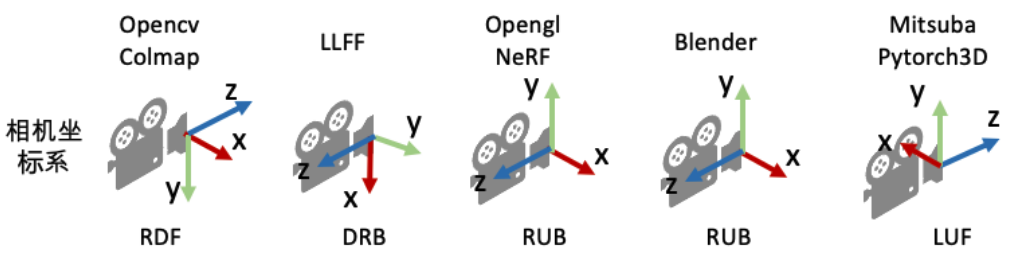

整体工作流程：  
(1)数据流  
config(读参数) -> load_data(加载相机位姿) -> get_rays_np(获得射线) -> render_rays -> MODEL PROCESS -> raw2output(转化输出，进行渲染)  
(2)模型流程，如下图：

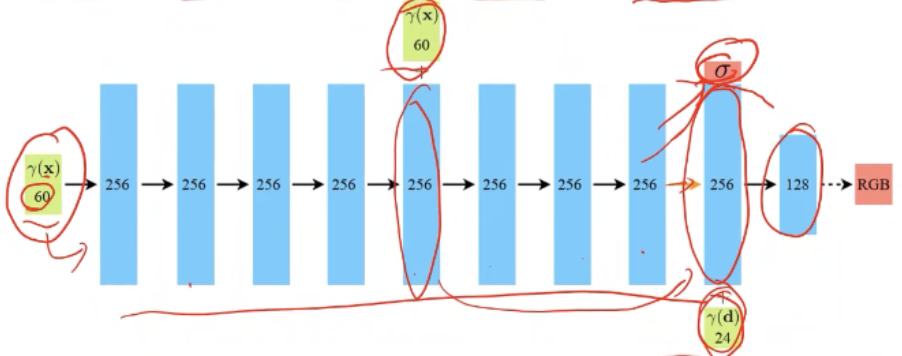

## <center>###数据处理的流(输入模型前与输出模型后)###</center>

补充：  
    注（1）参数矩阵(3,5)维度0~2为旋转，3平移，4内参  
    注（2）c2w(camera2world)坐标系解释：https://zhuanlan.zhihu.com/p/593204605/

### load_llff_data:

***进入_load_data:***

In [ ]:
# 经colmap创建SFM后，会得到相机的内外参数与景深，然后保存在poses_bounds.py里
poses = poses_arr[:, :-2].reshape([-1, 3, 5]).transpose([1,2,0]) # (N, 17) -> (3, 5, N)，注1
# function -> _minify(pass): 在终端操作文件夹复制，批量resize
poses[:2, 4, :] = np.array(sh[:2]).reshape([2, 1]) # 不要考虑(3,5,N)变形后是啥样，有啥物理意义。就当是两维的。这里更新了h、w
poses[2, 4, :] = poses[2, 4, :] * 1./factor #平移缩放，参考注2

【难点1】回到load_llff_data:

In [ ]:
poses = np.concatenate([poses[:, 1:2, :], -poses[:, 0:1, :], poses[:, 2:, :]], 1) # llff数据集坐标系变为nerf坐标系，此时nerf坐标下的camera2world
poses = np.moveaxis(poses, -1, 0).astype(np.float32) # (3, 5, N) -> (N, 3, 5)
poses[:,:3,3] *= sc # 平移伸长, 离中心近的伸长量小，离得远的伸长量大

【难点2】进入recenter_poses:

In [ ]:
# function -> poses_avg(pass): 计算所有相机的平均位姿，注2
c2w = np.concatenate([c2w[:3,:4], bottom], -2) #齐次化，这里的c2w是平均坐标系
poses = np.concatenate([poses[:,:3,:4], bottom], -2) #齐次化
poses = np.linalg.inv(c2w) @ poses # 将一个相机坐标系中的点变换到平均相机坐标系中，以便进行视角之间的转换。

***回到load_llff_data:***

In [ ]:
# function -> spherify_poses(pass)，注2，形成转圈视角
mean_dz = 1./(((1.-dt)/close_depth + dt/inf_depth)) #加权考虑近处和远处物体对于整个场景焦点的贡献，使得生成的图像能够在整个深度范围内保持清晰
zdelta = close_depth * .2 #压缩z，认为z基本不动，z是视角到物体距离
tt = poses[:,:3,3] # ptstocam(poses[:3,3,:].T, c2w).T
rads = np.percentile(np.abs(tt), 90, 0) #找一个渲染的辐射边界
c2w_path = c2w
N_views = 120 #待渲染点数
N_rots = 2 #旋转圈数

***进入render_path_spiral:***

In [ ]:
c = np.dot(c2w[:3,:4], np.array([np.cos(theta), -np.sin(theta), -np.sin(theta*zrate), 1.]) * rads) #返回世界坐标系下，一个扁球，视角到物体几乎不动
z = normalize(c - np.dot(c2w[:3,:4], np.array([0,0,-focal, 1.]))) #扁球z指向虚拟焦距
render_poses.append(np.concatenate([viewmatrix(z, up, c), hwf], 1)) #生成扁球上待渲染点的位姿，整体上是一个视锥

***回到load_llff_data:***

In [ ]:
i_test = np.argmin(dists) #找到距离平均点最近的拍照点

在创建网络时，要知道模型的输入输出是什么，因此需要先知道get_rays_np

### get_rays_np

In [ ]:
# 由像素坐标系转为相机坐标系
# i.shape (H,W)
dirs = np.stack([(i-K[0][2])/K[0][0], -(j-K[1][2])/K[1][1], -np.ones_like(i)], -1) #网格点归一化 (H,W,3)

【难点3】坐标系变换

In [ ]:
# 由相机坐标系转为世界坐标系
rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1) #(H,W,3)
rays_o = np.broadcast_to(c2w[:3,-1], np.shape(rays_d)) # c2w下相机的平移参数即为相机在世界坐标系下的x y z

### run_nerf

In [ ]:
# 原文677行
if use_batching: #把rgb信息加入到光线中
    """..."""
    rays = np.stack([get_rays_np(H, W, K, p) for p in poses[:,:3,:4]], 0) #(N,o+d,H,W,3)
    rays_rgb = np.concatenate([rays, images[:,None]], 1) # img:(N,1,H,W,3)
    rays_rgb = np.reshape(rays_rgb, [-1,3,3]) #((N-1)*H*W, o+d+rgb, 3)

***进入render:***

In [ ]:
rays_o, rays_d = rays #(o,B*H*W,3), (d,B*H*W,3)

In [ ]:
rays = torch.cat([rays_o, rays_d, near, far], -1)
    if use_viewdirs:
        rays = torch.cat([rays, viewdirs], -1)
# o=d,M=o*B*H*W,(M, rays_o*3, rays_d*3, near*1, far*1, view*3)

经过上述步骤，进入渲染模块前的数据维度为 (M/chunk, 11)，随后渲染模块再对射线采样

### render_rays:

【难点4】射线coarse采样：

均匀划分区间后，每个区间随机采样一个点

In [ ]:
mids = .5 * (z_vals[...,1:] + z_vals[...,:-1])
upper = torch.cat([mids, z_vals[...,-1:]], -1)
lower = torch.cat([z_vals[...,:1], mids], -1)
# stratified samples in those intervals
t_rand = torch.rand(z_vals.shape)
z_vals = lower + (upper - lower) * t_rand

In [ ]:
pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

经过上述步骤，进入模型前的数据维度为 (M/chunk, N_samples, 3)

## <center>###Model###</center>

### create_nerf:

In [ ]:
# function -> get_embedder(pass) #用3维图像生成60维位置编码 (N,3) -> (N,60)，用3维度视角生成24维位置编码 (N, 24)

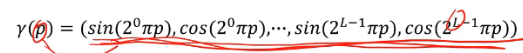

In [ ]:
if args.use_viewdirs: #因为材质和观察角度无关，获得材质后，需要加上视角信息，来获得后续颜色。
    embeddirs_fn, input_ch_views = get_embedder(args.multires_views, args.i_embed)

***进入run_network:***

In [ ]:
embedded = torch.cat([embedded, embedded_dirs], -1) # (N, 60+24)

进入batchify: 调用fn，而fn定义自237行的render_kwargs_train字典中的network_fn/network_fine，其又分别  
定义自create_nerf中的model和model_fine实例

因此让我们直接***跳到model构建：***

In [ ]:
# 模型分为粗网络和细网络，通过important points来确定
model = NeRF(D=args.netdepth, W=args.netwidth,
             input_ch=input_ch, output_ch=output_ch, skips=skips,
             input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs).to(device)

In [ ]:
# NeRF 模型难点1：确定输入是什么，为什么要split分开，（N,60）（N,24）
input_pts, input_views = torch.split(x, [self.input_ch, self.input_ch_views], dim=-1)

In [ ]:
# 输出 (N,4) = (N, rgb+sigma)

## <center>###render###</center>

### render_rays:

前文的render_rays和model部分，按处理顺序进行后，得到coarse网络的rgb和sigma输出，随后进入下一阶段

***进入raw2outputs:***

计算机图形学中渲染公式为：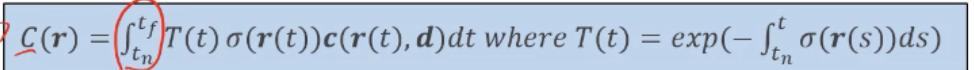

由蒙特卡洛离散法，可知：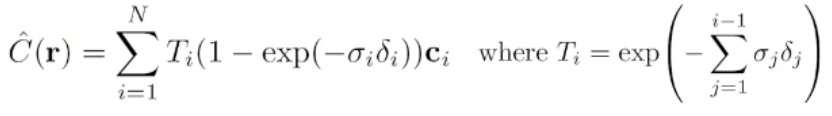

其中权重右边构建自275行：

In [ ]:
raw2alpha = lambda raw, dists, act_fn=F.relu: 1.-torch.exp(-act_fn(raw)*dists)

最后每个采样点的颜色权重构建自295行：

这里需要好好理解Ti公式，Ti每个点都要考虑之前所有点的透射影响

weights = alpha * torch.cumprod(torch.cat([torch.ones((alpha.shape[0], 1)), 1.-alpha + 1e-10], -1), -1)[:, :-1]

***回到render_rays, 进行fine模型采样：***

前文得到了每个点的概率密度，即可由pdf构建cdf累积分布函数，本段代码隐藏的关键部分就是，在非fine部分w几乎都是0，只有在接近材质表面时候，概率才会陡增，因此这里的概率u对应的点，其实都是精细化采样的目标点，即接近材质表面点。 

在sample_pdf中有：

In [ ]:
cdf = torch.cumsum(pdf, -1)
cdf = torch.cat([torch.zeros_like(cdf[...,:1]), cdf], -1)  # (batch, len(bins))
# ...
t = (u-cdf_g[...,0])/denom
samples = bins_g[...,0] + t * (bins_g[...,1]-bins_g[...,0])

***回到render_rays:***

In [ ]:
pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # (N_rays, N_samples + N_importance, 3)

将fine模型的结果再次输入raw2outputs，渲染后可得颜色。然后进行loss约束即可。